# Модуль А. Анализ и предобработка данных

## Импорт библиотек

In [1]:
# для преобразований фотографий
import cv2
from PIL import Image

# для работы с файловой системой
import os
import shutil

# модуль с более удобными словарями
from collections import defaultdict

# для разбиения на выборки
from sklearn.model_selection import train_test_split

# для визуализации
import matplotlib.pyplot as plt

# для прогресс баров
from tqdm import tqdm

# для вычисления хэша 
import hashlib

# для подгрузки дополнительных данных
import kagglehub

# для случайных элементов
import random

# для разархивации
import zipfile

d:\Helper\MLBazyak\chemp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# получаем корневой путь
main_dir = os.getcwd()[:-8]
# получаем путь к модулю
module_dir = os.getcwd()
# логирование
print('Текущий путь к модулю', module_dir)
print("Текущая корневая директория:", main_dir)

Текущий путь к модулю d:\Helper\MLBazyak\chemp\face_recognitionV2\Module1
Текущая корневая директория: d:\Helper\MLBazyak\chemp\face_recognitionV2


## Загрузка данных

в качестве данных, я получил архив с названием `Датасеты25.zip`. для начала работы, нужно их разархивировать.

Используя утилиту `WinRAR` я разархивировал папку `Датасеты25` в директорию `Data\`, а также переименовал папку на `Data25`, так как с русскими путями часто бывают проблемы. Папку для `MacOS` я решил не использовать

In [74]:
# путь к основной папке с данными
data_path = os.path.join(main_dir, r'Data\Data25')
# список всех представленных папок (датасетов)
datas_list = os.listdir(data_path)
# логирование
print(f'Папка с данными: {data_path}')
print(f'Всего предлагаемых датасетов: {len(datas_list)}')
print(f'Представленные папки: {datas_list}')

Папка с данными: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25
Всего предлагаемых датасетов: 5
Представленные папки: ['archive', 'archive-3', 'Custom_Data', 'faces', 'face_detection']


## Датасет 1: archive

### Структура данных в наборе


    -> archive\     # главная папка
        -> Extracted Faces\Extracted Faces\     # папка с кропнутыми лицами
            -> 0\       # "именная" папка
                -> 0.jpg        # фотография
                -> 1.jpg        # фотография
                
            -> 1\      
                -> 0.jpg
                -> 1.jpg

        -> Face Data\Face Dataset\      # папка с цельными лицами
            -> 0\       # "именная" папка
                -> 0.jpg        # фотография      
                -> 1.jpg        # фотография      

            -> 1\
                -> 0.jpg
                -> 1.jpg

In [148]:
# получаем путь к первому датасету (archive)
path_to_data1 = os.path.join(data_path, datas_list[0])
# логирование
print(f'Путь к первому датасету: {path_to_data1}')

Путь к первому датасету: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive


В датасете представлены `2` основные папки - просто с фотографиями с лицами, и с кропами лиц тех же самых фотографий 

In [7]:
print(os.listdir(path_to_data1)) # 2 основные папки, и файл с логами
# получааем путь к папке с кропами
extracted_face_data1 = os.path.join(path_to_data1, r'Extracted Faces\Extracted Faces')
print(f'Путь к папке с кропами: {extracted_face_data1}')
# получаем путь к папке с целыми фото
face_data1 = os.path.join(path_to_data1, r'Face Data\Face Dataset')
print(f'Путь к папке с целыми фото: {face_data1}')

['Extracted Faces', 'Face Data']
Путь к папке с кропами: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive\Extracted Faces\Extracted Faces
Путь к папке с целыми фото: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive\Face Data\Face Dataset


### Анализ датасета, баланс классов, проверка пропусков

Датасет с кропами: всего 1324 папок


Датасет с кропами: сбор данных..: 100%|██████████| 1324/1324 [00:00<00:00, 13244.84folder/s]

Датасет с кропами: всего 6107 фотографий


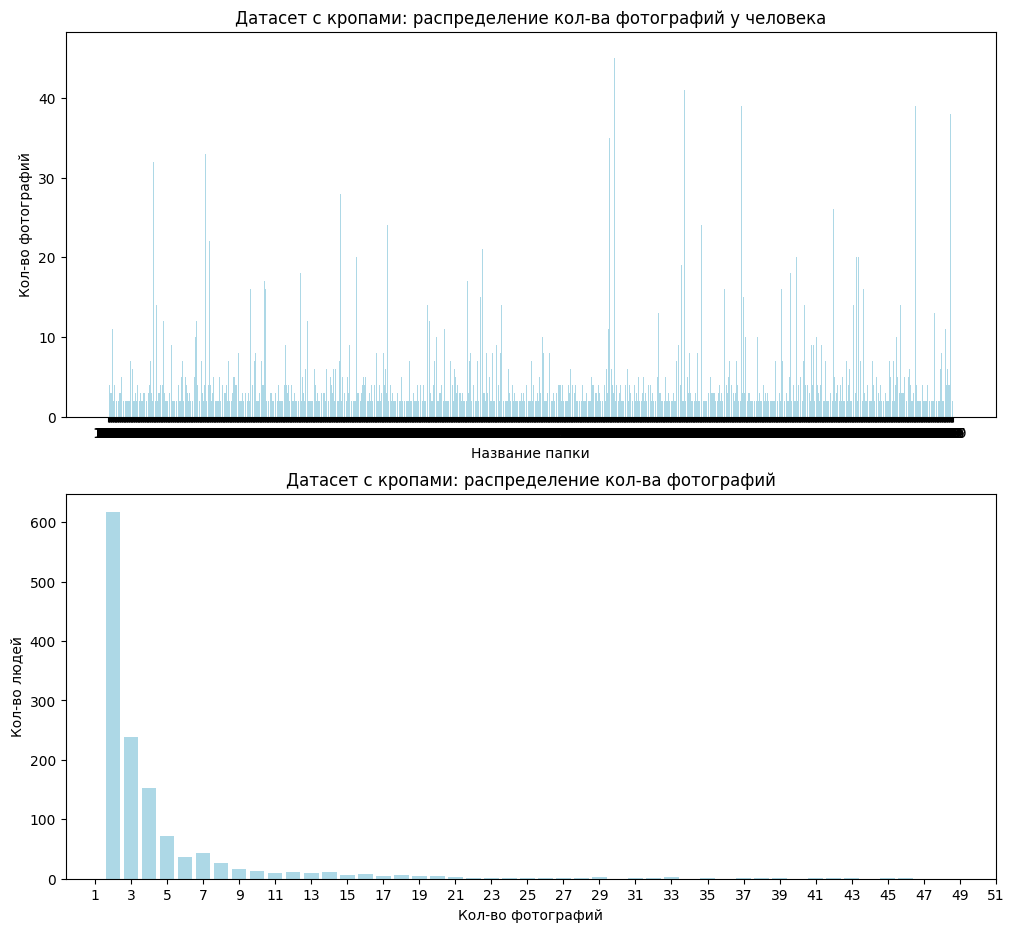

Максимальное кол-во: 46, номер папки - 1588
Топ 5 минимальных по заполненности значений у папки: [2, 3, 4, 5, 6]
-----------------------------------
Датасет с фотографиями: всего 1680 папок


Датасет с фотографиями: сбор данных..: 100%|██████████| 1680/1680 [00:00<00:00, 29676.80folder/s]

Датасет с фотографиями: всего 8204 фотографий


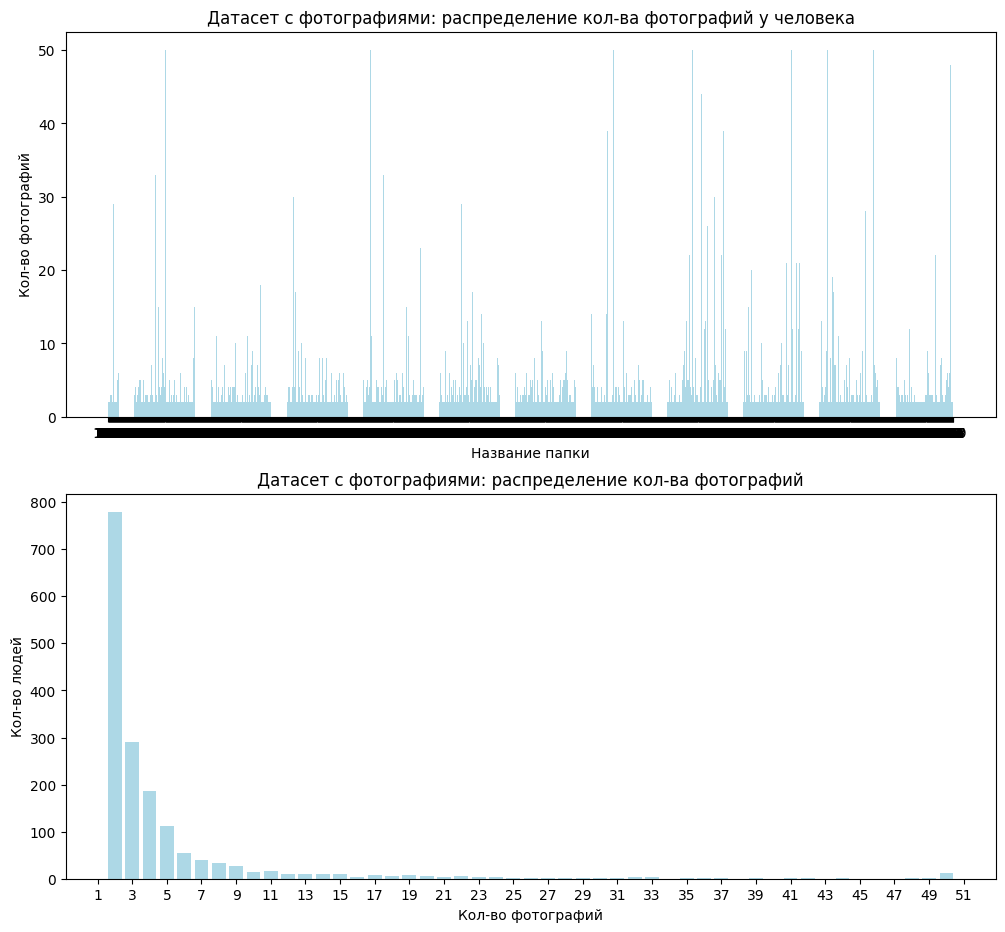

Максимальное кол-во: 50, номер папки - 110
Топ 5 минимальных по заполненности значений у папки: [2, 3, 4, 5, 6]
-----------------------------------


In [16]:
# список с именами датасетов
data_names = ['Датасет с кропами', 'Датасет с фотографиями']
datas = [extracted_face_data1, face_data1]

# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]
    # логирование
    print(f'{data_names[i]}: всего {len(os.listdir(datas[i]))} папок')
    # счетчик фотографий
    counter = 0
    # 
    max_name, max_value = 0,0
    # словарь для статистики
    nums_stats = defaultdict(int)
    value_stats = defaultdict(int)
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(data), desc=f'{data_names[i]}: сбор данных..', unit='folder'):
        # получаем путь к папке
        folder_path = os.path.join(datas[i], folder)
        # обновляем счетчик и вводим статистику в словарь
        img_nums = len(os.listdir(folder_path))
        #
        if img_nums > max_value:
            max_value=img_nums
            max_name=folder

        counter+=img_nums
        
        nums_stats[folder]=img_nums
        value_stats[img_nums]+=1

    print(f'{data_names[i]}: всего {counter} фотографий')

    # парсим получившийся словарь
    nums = nums_stats.values()
    folders = nums_stats.keys()

    fig, ax = plt.subplots(2,1,figsize=(12,11))
    # визуализируем результат
    ax[0].bar(folders, nums, color='lightblue')
    ax[0].set_title(f'{data_names[i]}: распределение кол-ва фотографий у человека')
    ax[0].set_xlabel('Название папки')
    ax[0].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    value = value_stats.keys()
    # визуализируем результат
    ax[1].bar(value, counts, color='lightblue')
    ax[1].set_title(f'{data_names[i]}: распределение кол-ва фотографий')
    ax[1].set_xlabel('Кол-во фотографий')
    ax[1].set_ylabel('Кол-во людей')
    ax[1].set_xticks(range(1,52,2))
    plt.show()
    # логирование
    print(f'Максимальное кол-во: {max_value}, номер папки - {max_name}')
    print('Топ 5 минимальных по заполненности значений у папки:', list(set(list(value)))[0:5])
    print('-----------------------------------')



**По результатам анализа можно заметить что:**

- в каждой папке есть минимум 2 фотографии (нет пропусков в датасете)
- макс кол-во фотографий у датасета с кропами: `46`
- макс кол-во фотографий у датасета с целыми фотографиями: `50`
- у большинства людей из папок по 2 фотографии
- в датасете с кропами на `356` папок меньше, чем в полных фотографиях (от них надо избавиться)

### Проверка на формат фотографий в датасете

Датасет с кропами: анализ..: 100%|██████████| 1324/1324 [00:01<00:00, 1321.01folder/s]


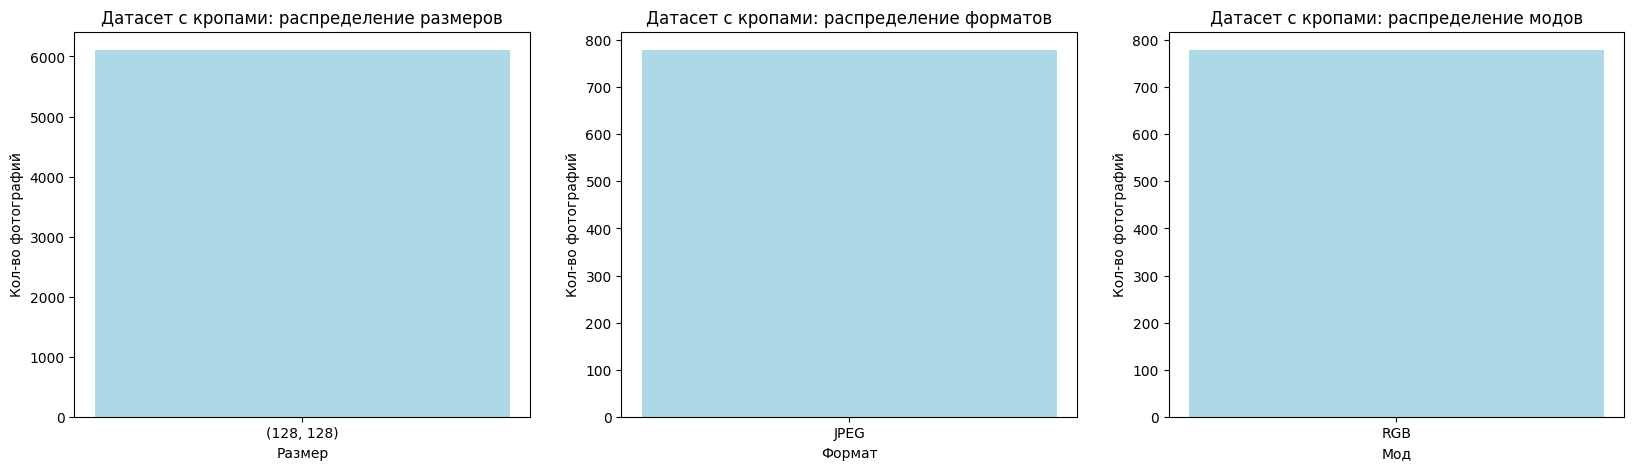

Датасет с фотографиями: анализ..: 100%|██████████| 1680/1680 [00:01<00:00, 1442.02folder/s]


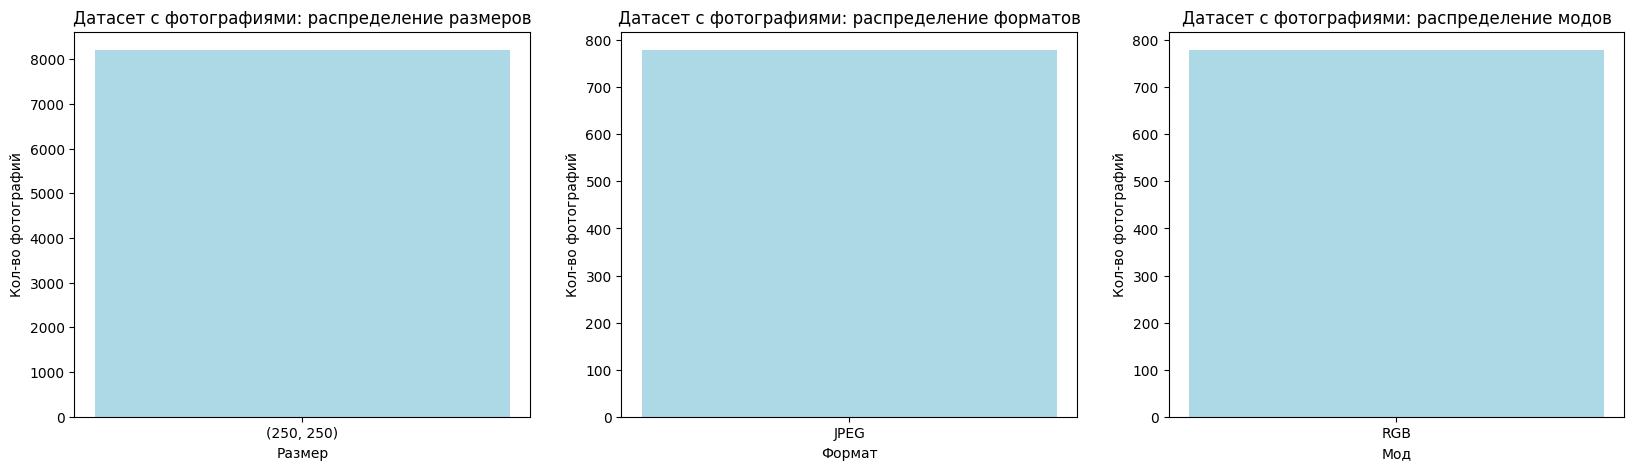

In [12]:
# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]

    # словари для статистики
    mode_stats = defaultdict(int)
    size_stats = defaultdict(int)
    format_stats = defaultdict(int)
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(datas[i]), desc=f'{data_names[i]}: анализ..', unit='folder'):
        # путь к папке
        folder_path = os.path.join(datas[i], folder)
        # проходимся по каждой фотографии в папке
        for img in os.listdir(folder_path):
            # путь к фотографии
            img_path = os.path.join(folder_path, img)
            # открываем фотографию испльзуя pillow
            img = Image.open(img_path)
            # обновляем словари
            size_stats[f'{img.size}']+=1
            format_stats[img.format]+=1
            mode_stats[img.mode]+=1

    # разбиваем график на несколько
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    # парсим получившийся словарь
    counts = size_stats.values()
    size = size_stats.keys()
    # визуализируем результат
    ax[0].bar(size, counts, color='lightblue')
    ax[0].set_title(f'{data_names[i]}: распределение размеров')
    ax[0].set_xlabel('Размер')
    ax[0].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    format_ = format_stats.keys()
    # визуализируем результат
    ax[1].bar(format_, counts, color='lightblue')
    ax[1].set_title(f'{data_names[i]}: распределение форматов')
    ax[1].set_xlabel('Формат')
    ax[1].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    mode = mode_stats.keys()
    # визуализируем результат
    ax[2].bar(mode, counts, color='lightblue')
    ax[2].set_title(f'{data_names[i]}: распределение модов')
    ax[2].set_xlabel('Мод')
    ax[2].set_ylabel('Кол-во фотографий')

    plt.show()    

Можно заметить, что `размер`, `мод` и `формат` у всех изображений на каждой папке одинаковый, так что датасеты приведены к стандартизированному формату

### Проверка датасета на дубликаты

In [84]:
# функция для вычисления хэша
def calculate_hash(image_path):
    '''Вычисляет хеш изображения.'''
    # открываем фотографию
    with open(image_path, "rb") as f:
        # извлекаем хэш
        return hashlib.md5(f.read()).hexdigest()

In [ ]:
# словарь с хэшами
hash_dict = {}
# список с дубликатами
duplicates = []

# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(data), desc=f'{data_names[i]}: поиск дубликатов..', unit='folder'):
        # путь к папке
        folder_path = os.path.join(datas[i], folder)
        # проходимся по каждой фотографии в папке
        for img in os.listdir(folder_path):
            # путь к фотографии
            img_path = os.path.join(folder_path, img)
            # вычисляем хэш
            image_hash = calculate_hash(img_path)
            # првоеряем, есть ли такой хэш в словаре
            if image_hash in hash_dict:
                # если да, то обновляем список с дубликатами
                duplicates.append((img_path, hash_dict[image_hash]))
            # если нет, то добавляем хэш в словарь
            else:
                hash_dict[image_hash] = img_path
    # если дубликаты есть
    if duplicates:
        print(f'{data_names[i]}: найдены дубликаты')
        for dup in duplicates:
            print(f"Дубликат: {dup[0]} и {dup[1]}")
    # если дубликатов нет
    else:
        print(f'{data_names[i]}: дубликаты не найдены')
    # логирование
    print('Поиск дубликатов закончен')


Датасет с кропами: поиск дубликатов..: 100%|██████████| 1324/1324 [00:00<00:00, 2215.99folder/s]


Датасет с кропами: дубликаты не найдены
Поиск дубликатов закончен


Датасет с фотографиями: поиск дубликатов..: 100%|██████████| 1680/1680 [00:01<00:00, 1462.96folder/s]

Датасет с фотографиями: дубликаты не найдены
Поиск дубликатов закончен


**Дубликаты не были обнаружены**

## Датасет 2: archive-3

### Структура данных в наборе

In [79]:
# получаем путь ко второму датасету (archive-3)
path_to_data2 = os.path.join(data_path, datas_list[1])
# логирование
print(f'Путь ко второму датасету: {path_to_data2}')

Путь ко второму датасету: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3



    -> archive-3\     # главная папка
        -> Faces\Faces\     # папка с кропнутыми лицами
            -> Akshay Kumar_0.jpg        # фотография
            -> Akshay Kumar_1.jpg        # фотография
            -> Akshay Kumar_2.jpg        # фотография
            -> Akshay Kumar_3.jpg        # фотография
            -> etc ...
        
        -> Original Images\     # папка с именными папками с цельными фото
            -> Akshay Kumar\     # именная папка 
                -> Akshay Kumar_0.jpg       # фотография
                -> Akshay Kumar_1.jpg       # фотография      
                -> Akshay Kumar_2.jpg       # фотография
                -> Akshay Kumar_3.jpg       # фотография    

            -> Alia Bhatt\
            -> Camila Cabello\
            -> etc ...

        -> Dataset.csv      # csv файл с названием файла и именем человека на фото



Выведем, что в папке `archive-3`

In [80]:
print(os.listdir(path_to_data2))

['Dataset.csv', 'Faces', 'Original Images']


In [81]:
# пути к папкам с кропами и к оригинальным фото
faces_path = os.path.join(path_to_data2, r'Faces\Faces')
orig_img_faces = os.path.join(path_to_data2, r'Original Images\Original Images')
# получим список файлов по этим путям
faces_data = os.listdir(faces_path)
orig_img_data = os.listdir(orig_img_faces)

### Анализ датасета, баланс классов, проверка пропусков

Папка с кропами лиц: 2562 фотографий
Папка с оригинальными фотографиями: 31 имен
Всего фотографий в оригинальных папках: 2562


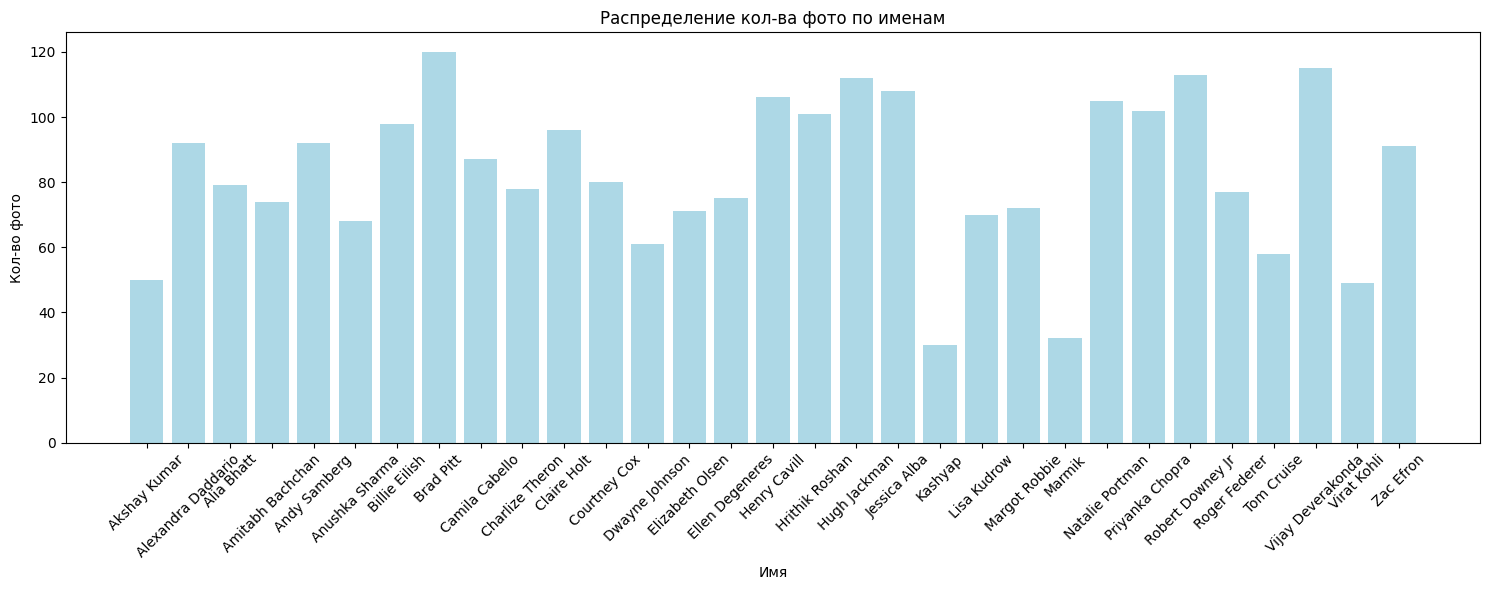

У Brad Pitt наибольшее кол-во фотографий - 120


In [82]:
# логирование
print('Папка с кропами лиц:',len(faces_data), 'фотографий')
print('Папка с оригинальными фотографиями:',len(orig_img_data), 'имен')
# счетчик
counter = 0
# макс кол-во фотографий
max_name, max_img = '', 0
# словарь для статистики
nums_stats = defaultdict(int)
# проходимся по каждой папке
for name in orig_img_data:
    # путь к имени
    name_path = os.path.join(orig_img_faces, name)
    # кол-во фотографий
    img_count = len(os.listdir(name_path))
    # обновляем счетчик
    counter+=img_count
    # обновляем словарь
    nums_stats[name] = img_count
    # ищем макс колво фотографий
    if img_count > max_img:
        max_img = img_count
        max_name = name

print(f'Всего фотографий в оригинальных папках: {counter}')
# парсим словарь
names = list(nums_stats.keys())
img_count = list(nums_stats.values())
# визуализация результатов
plt.figure(figsize=(15,6))
plt.bar(names, img_count, color='lightblue')
plt.xlabel('Имя')
plt.ylabel('Кол-во фото')
plt.xticks(names, rotation=45)
plt.title('Распределение кол-ва фото по именам')
plt.tight_layout()
plt.show()

# макс колво фото
print(f'У {max_name} наибольшее кол-во фотографий - {max_img}')

всего в датасете `31` человек, и `2562`

### Проверка дубликатов

**Датасет с кропами:**

In [85]:
# словарь с хэшами
hash_dict = {}
# список с дубликатами
duplicates = []

# проходимся по каждой фотографии в папке
for img in tqdm(faces_data, desc=f'Датасет с кропами: поиск дубликатов..', unit='image'):
    # путь к фотографии
    img_path = os.path.join(faces_path, img)
    # вычисляем хэш
    image_hash = calculate_hash(img_path)
    # првоеряем, есть ли такой хэш в словаре
    if image_hash in hash_dict:
        # если да, то обновляем список с дубликатами
        duplicates.append((img_path, hash_dict[image_hash]))
    # если нет, то добавляем хэш в словарь
    else:
        hash_dict[image_hash] = img_path
        
# если дубликаты есть
if duplicates:
    print(f'Датасет с кропами: найдены дубликаты - {len(duplicates)} штук')
    for dup in duplicates:
        print(f"Дубликат: {dup[0]} и {dup[1]}")
        # удаляем найденные дубликаты
        os.remove(dup[0])
        os.remove(dup[1])

# если дубликатов нет
else:
    print(f'Датасет с кропами: дубликаты не найдены')
# логирование
print(f'Итоговое кол-во фото: {len(os.listdir(faces_path))}')
print('Поиск дубликатов закончен')


Датасет с кропами: поиск дубликатов..: 100%|██████████| 2562/2562 [00:31<00:00, 82.30image/s]

Датасет с кропами: найдены дубликаты - 5 штук
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Courtney Cox_45.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Courtney Cox_23.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Courtney Cox_9.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Courtney Cox_10.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Henry Cavill_5.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Henry Cavill_25.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Hugh Jackman_83.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Hugh Jackman_82.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Natalie Portman_93.jpg и d:\Helper\M

**Датасет с оригинальными фотографиями:**

In [86]:
# словарь с хэшами
hash_dict = {}
# список с дубликатами
duplicates = []

# проходимся по каждой папке
for folder in tqdm(orig_img_data, desc=f'Датасет с оригиналами: поиск дубликатов..', unit='folder'):
    # путь к папке
    folder_path = os.path.join(orig_img_faces, folder)
    # проходимся по каждой фотографии в папке
    for img in os.listdir(folder_path):
        # путь к фотографии
        img_path = os.path.join(folder_path, img)
        # вычисляем хэш
        image_hash = calculate_hash(img_path)
        # првоеряем, есть ли такой хэш в словаре
        if image_hash in hash_dict:
            # если да, то обновляем список с дубликатами
            duplicates.append((img_path, hash_dict[image_hash]))
        # если нет, то добавляем хэш в словарь
        else:
            hash_dict[image_hash] = img_path

# если дубликаты есть
if duplicates:
    print(f'Датасет с оригиналами: найдены дубликаты - {len(duplicates)} штук')
    for dup in duplicates:
        print(f"Дубликат: {dup[0]} и {dup[1]}")
        # удаляем найденные дубликаты
        os.remove(dup[0])
        os.remove(dup[1])

# если дубликатов нет
else:
    print(f'Датасет с оригиналами: дубликаты не найдены')
# логирование
print('Дубликаты удалены')
print('Поиск дубликатов закончен')


Датасет с оригиналами: поиск дубликатов..: 100%|██████████| 31/31 [00:57<00:00,  1.87s/folder]

Датасет с оригиналами: найдены дубликаты - 4 штук
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Courtney Cox\Courtney Cox_45.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Courtney Cox\Courtney Cox_23.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Courtney Cox\Courtney Cox_9.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Courtney Cox\Courtney Cox_10.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Hugh Jackman\Hugh Jackman_83.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Hugh Jackman\Hugh Jackman_82.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Natalie Portman\Natal

### Проверка на формат изображений в датасетах

**Датасет с кропами**

Датасет с кропами: анализ фото..: 100%|██████████| 2552/2552 [00:00<00:00, 3615.80images/s]


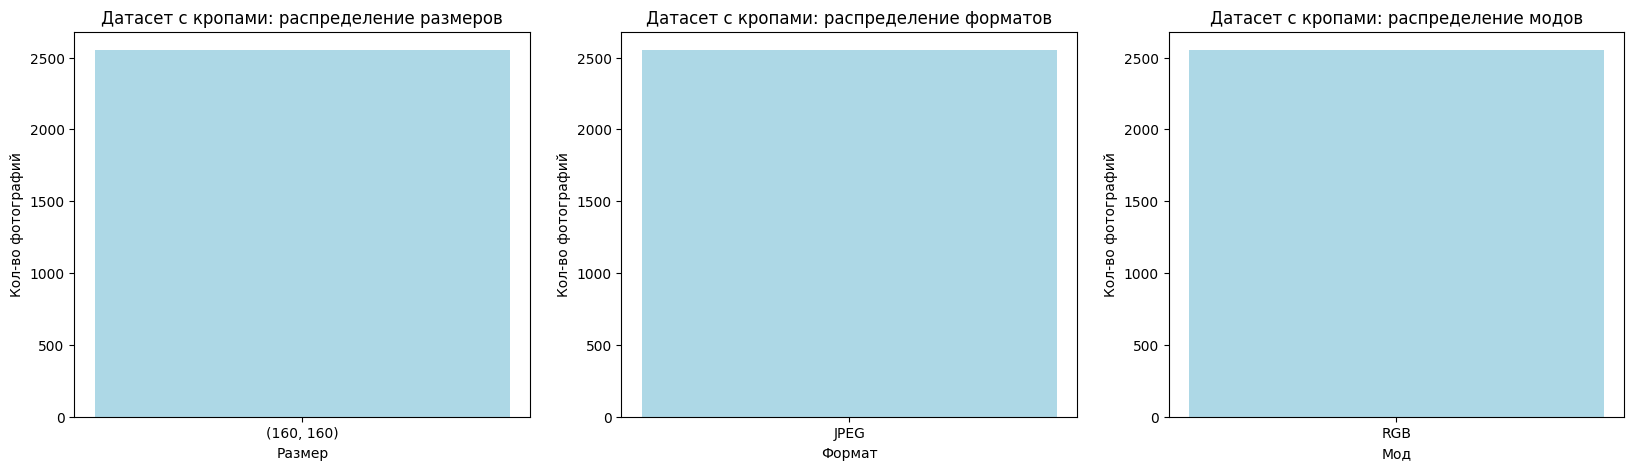

In [87]:
# словари для статистики
mode_stats = defaultdict(int)
size_stats = defaultdict(int)
format_stats = defaultdict(int)

# проходимся по каждой фотографии в папке
for img in tqdm(os.listdir(faces_path), desc='Датасет с кропами: анализ фото..', unit='images'):
    # путь к фотографии
    img_path = os.path.join(faces_path, img)
    # открываем фотографию испльзуя pillow
    img = Image.open(img_path)
    # обновляем словари
    size_stats[f'{img.size}']+=1
    format_stats[img.format]+=1
    mode_stats[img.mode]+=1

# разбиваем график на несколько
fig, ax = plt.subplots(1,3,figsize=(20,5))
# парсим получившийся словарь
counts = size_stats.values()
size = size_stats.keys()
# визуализируем результат
ax[0].bar(size, counts, color='lightblue')
ax[0].set_title(f'Датасет с кропами: распределение размеров')
ax[0].set_xlabel('Размер')
ax[0].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = format_stats.values()
format_ = format_stats.keys()
# визуализируем результат
ax[1].bar(format_, counts, color='lightblue')
ax[1].set_title(f'Датасет с кропами: распределение форматов')
ax[1].set_xlabel('Формат')
ax[1].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = mode_stats.values()
mode = mode_stats.keys()
# визуализируем результат
ax[2].bar(mode, counts, color='lightblue')
ax[2].set_title(f'Датасет с кропами: распределение модов')
ax[2].set_xlabel('Мод')
ax[2].set_ylabel('Кол-во фотографий')

plt.show()    

Все фотографии в датасете с кропами одного `размера`, `мода` и `формата`

**Датасет с оригинальными фотографиями: - так как он будет использоваться только для вывода и не будет использоваться в обучении модели, его менять не обязательно**

Датасет с оригиналами: анализ фото..: 100%|██████████| 31/31 [00:00<00:00, 64.16images/s]


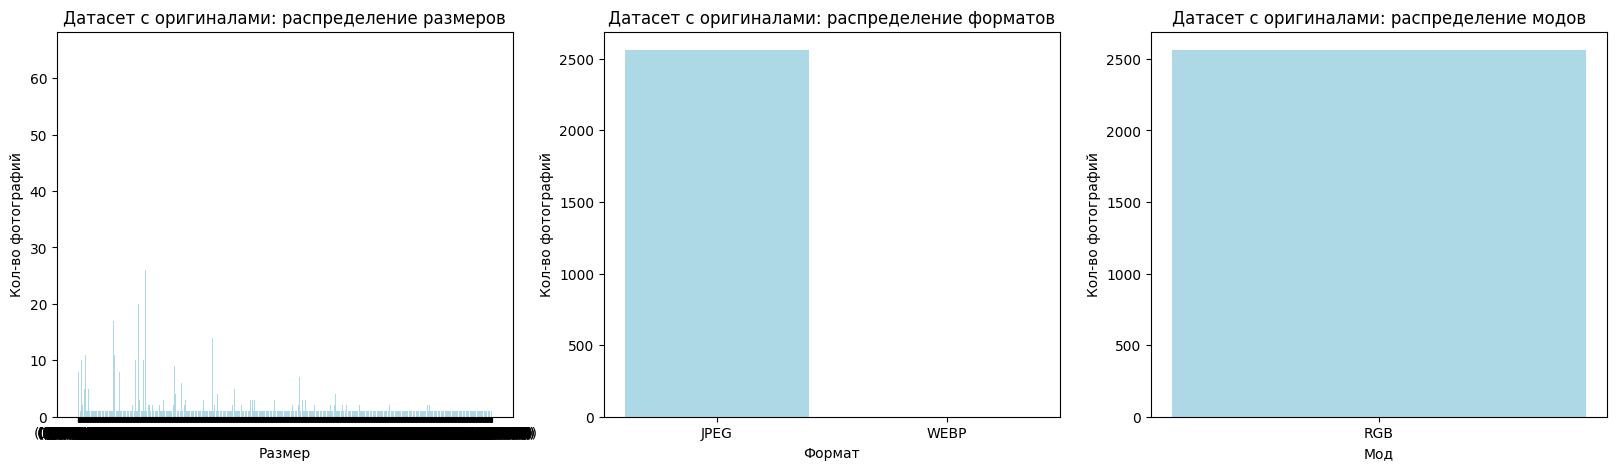

In [66]:

# словари для статистики
mode_stats = defaultdict(int)
size_stats = defaultdict(int)
format_stats = defaultdict(int)
# проходимся по каждой папке 
for folder in tqdm(os.listdir(orig_img_faces), desc='Датасет с оригиналами: анализ фото..', unit='images'):
    # путь к папке
    folder_path = os.path.join(orig_img_faces, folder)
    # проходимся по каждой фотографии в папке
    for img in os.listdir(folder_path):
        # путь к фотографии
        img_path = os.path.join(folder_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # обновляем словари
        size_stats[f'{img.size}']+=1
        format_stats[img.format]+=1
        mode_stats[img.mode]+=1

# разбиваем график на несколько
fig, ax = plt.subplots(1,3,figsize=(20,5))
# парсим получившийся словарь
counts = size_stats.values()
size = size_stats.keys()
# визуализируем результат
ax[0].bar(size, counts, color='lightblue')
ax[0].set_title(f'Датасет с оригиналами: распределение размеров')
ax[0].set_xlabel('Размер')
ax[0].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = format_stats.values()
format_ = format_stats.keys()
# визуализируем результат
ax[1].bar(format_, counts, color='lightblue')
ax[1].set_title(f'Датасет с оригиналами: распределение форматов')
ax[1].set_xlabel('Формат')
ax[1].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = mode_stats.values()
mode = mode_stats.keys()
# визуализируем результат
ax[2].bar(mode, counts, color='lightblue')
ax[2].set_title(f'Датасет с оригиналами: распределение модов')
ax[2].set_xlabel('Мод')
ax[2].set_ylabel('Кол-во фотографий')

plt.show()    

Все фотографии одного `мода`, но разного `размера` и несколько фотографий другого `формата`

In [73]:
# новый размер фотографий
new_size = (640,640)
# проходимся по каждой папке 
for folder in tqdm(os.listdir(orig_img_faces), desc='Датасет с оригиналами: преобразование фото..', unit='images'):
    # путь к папке
    folder_path = os.path.join(orig_img_faces, folder)
    # проходимся по каждой фотографии в папке
    for img in os.listdir(folder_path):
        # путь к фотографии
        img_path = os.path.join(folder_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # меняем размер фотографий
        img = img.resize(new_size, resample=Image.Resampling.LANCZOS)
        # новый путь
        new_path = img_path.split('.')[0]+'.jpg'
        # меняем формат фотографии и сохраняем
        img = img.save(new_path, format='JPEG')

Датасет с оригиналами: преобразование фото..: 100%|██████████| 31/31 [01:31<00:00,  2.94s/images]


После преобразований, проверим еще раз информацию по фотографиям:

Датасет с оригиналами: анализ фото..: 100%|██████████| 31/31 [00:26<00:00,  1.16folder/s]


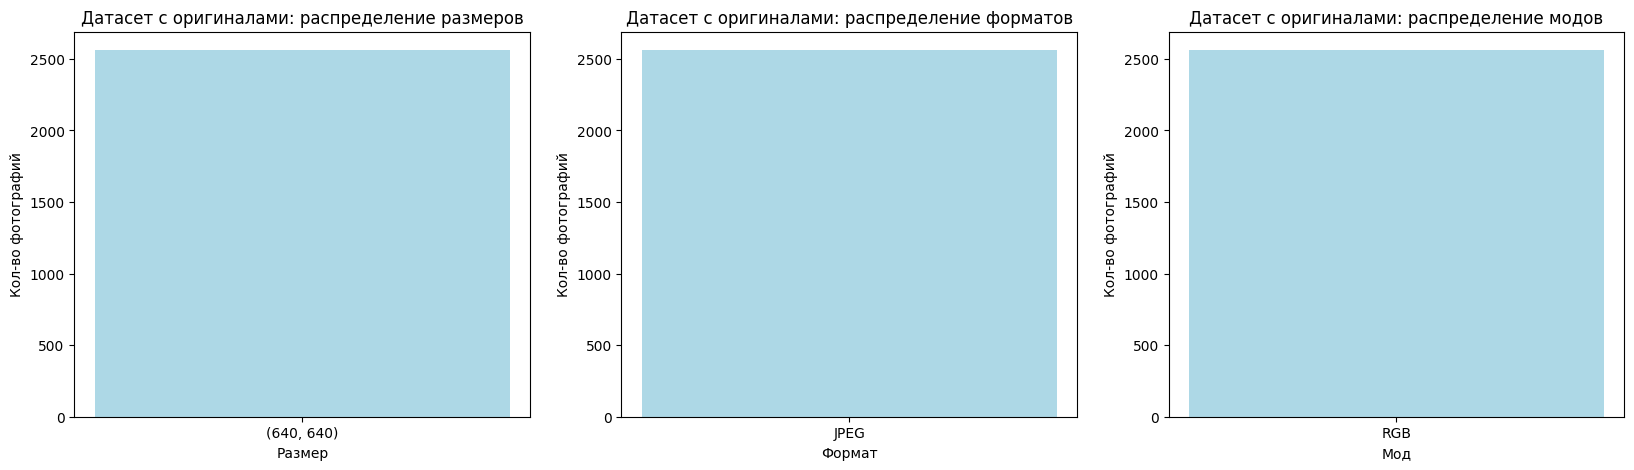

In [75]:

# словари для статистики
mode_stats = defaultdict(int)
size_stats = defaultdict(int)
format_stats = defaultdict(int)
# проходимся по каждой папке 
for folder in tqdm(os.listdir(orig_img_faces), desc='Датасет с оригиналами: анализ фото..', unit='folder'):
    # путь к папке
    folder_path = os.path.join(orig_img_faces, folder)
    # проходимся по каждой фотографии в папке
    for img in os.listdir(folder_path):
        # путь к фотографии
        img_path = os.path.join(folder_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # обновляем словари
        size_stats[f'{img.size}']+=1
        format_stats[img.format]+=1
        mode_stats[img.mode]+=1

# разбиваем график на несколько
fig, ax = plt.subplots(1,3,figsize=(20,5))
# парсим получившийся словарь
counts = size_stats.values()
size = size_stats.keys()
# визуализируем результат
ax[0].bar(size, counts, color='lightblue')
ax[0].set_title(f'Датасет с оригиналами: распределение размеров')
ax[0].set_xlabel('Размер')
ax[0].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = format_stats.values()
format_ = format_stats.keys()
# визуализируем результат
ax[1].bar(format_, counts, color='lightblue')
ax[1].set_title(f'Датасет с оригиналами: распределение форматов')
ax[1].set_xlabel('Формат')
ax[1].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = mode_stats.values()
mode = mode_stats.keys()
# визуализируем результат
ax[2].bar(mode, counts, color='lightblue')
ax[2].set_title(f'Датасет с оригиналами: распределение модов')
ax[2].set_xlabel('Мод')
ax[2].set_ylabel('Кол-во фотографий')

plt.show()    

Теперь, все фотографии сохранены в одном `размере`, `формате` и `моде`

## Датасет 3: faces

### Структура данных в наборе

In [16]:
# получаем путь к третьему (archive-3)
path_to_data3 = os.path.join(data_path, 'faces')
# логирование
print(f'Путь к третьему датасету: {path_to_data3}')

Путь к третьему датасету: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces


смотрим, что находится в этом датасете

In [17]:
print(os.listdir(path_to_data3))

['man', 'woman']


In [18]:
# получаем путь к папке с мужчинами, и с женщинами
mans_path = os.path.join(path_to_data3, 'man')
womans_path = os.path.join(path_to_data3, 'woman')
# получаем списки с набором данных
mans_data = os.listdir(mans_path)
womans_data = os.listdir(womans_path)
# проверка путей
print(f'Кол-во мужских фотографий: {len(mans_data)}')
print(f'Кол-во женских фотографий: {len(womans_data)}')


Кол-во мужских фотографий: 17449
Кол-во женских фотографий: 9380



    -> faces\     # главная папка
        -> man\     # папка с мужскими фотографиями лиц
            -> man_0.jpg        # фотография
            -> man_1.jpg        # фотография
            -> man_2.jpg        # фотография
            -> man_3.jpg        # фотография
            -> man_4.jpg        # фотография
            -> etc ...
        
        -> woman\     # папка с женскими фотографиями лиц
            -> woman_0.jpg        # фотография
            -> woman_1.jpg        # фотография
            -> woman_2.jpg        # фотография
            -> woman_3.jpg        # фотография
            -> woman_4.jpg        # фотография
            -> etc ...



### Анализ датасета, баланс классов, проверка пропусков

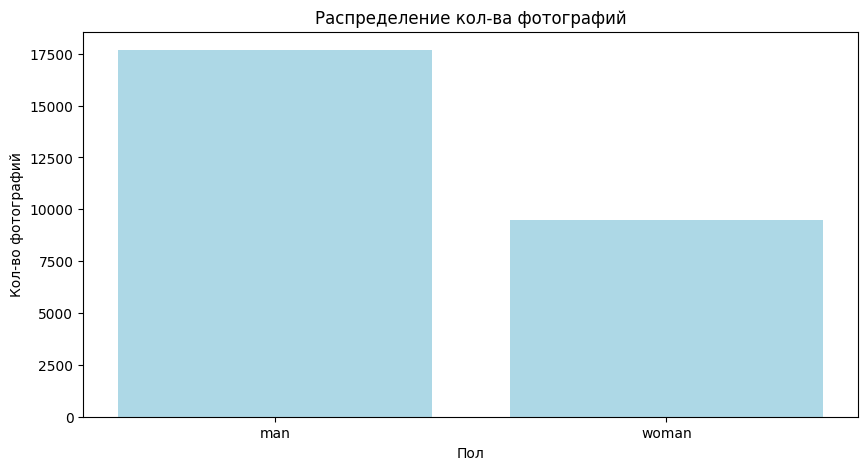

In [32]:
# баланс классов (женщины\мужчины)
plt.figure(figsize=(10,5))
plt.bar(['man', 'woman'],[len(mans_data), len(womans_data)], color='lightblue')
plt.title('Распределение кол-ва фотографий')
plt.xlabel('Пол')
plt.ylabel('Кол-во фотографий')
plt.show() 

**В каждой папке есть минимум `1` изображение, так что пропусков нет**

### Проверка на формат изображений в датасетах

Датасет с мужчинами: анализ фото..: 100%|██████████| 17678/17678 [01:44<00:00, 169.42images/s]


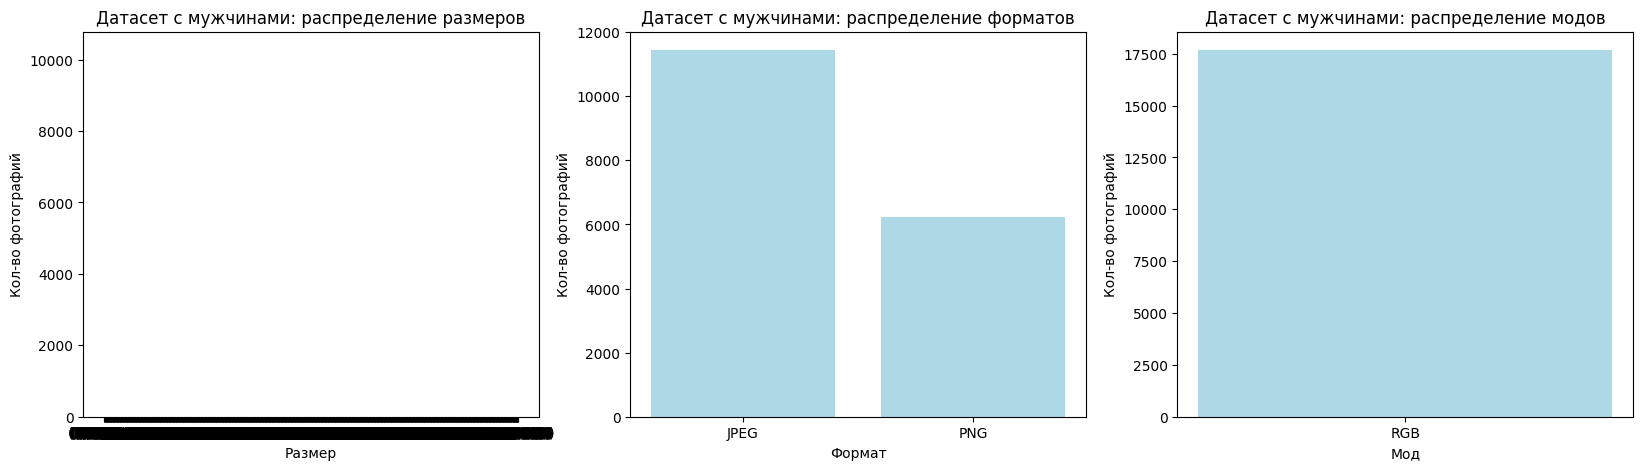

Кол-во различных размеров: 1118
-----------------


Датасет с женщинами: анализ фото..: 100%|██████████| 9489/9489 [02:03<00:00, 76.80images/s] 


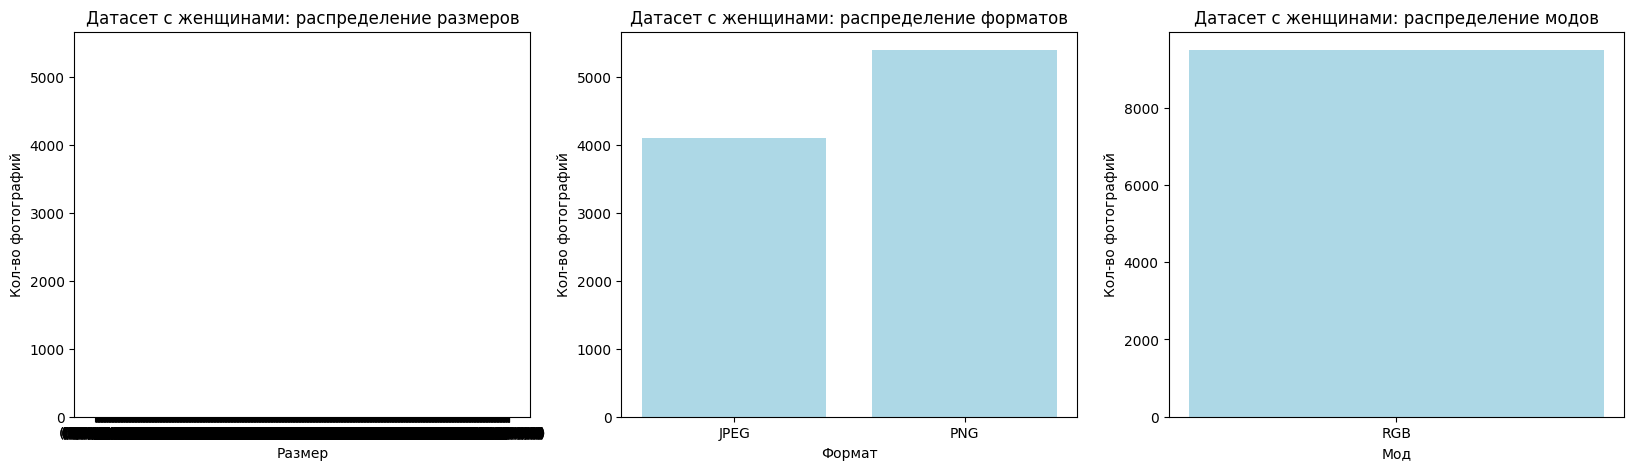

Кол-во различных размеров: 1097
-----------------


In [35]:
# назначаем списки с кусками датасетов
datas = [mans_data, womans_data]
data_names = ['Датасет с мужчинами', 'Датасет с женщинами']
data_paths = [mans_path, womans_path]
# проходимся по каждому набору
for i in range(len(datas)):
    # получаем набор даных, его имя и путь
    data = datas[i] 
    data_name = data_names[i]
    data_path = data_paths[i]
    # словари для статистики
    mode_stats = defaultdict(int)
    size_stats = defaultdict(int)
    format_stats = defaultdict(int)

    # проходимся по каждой фотографии в папке
    for img in tqdm(data, desc=f'{data_name}: анализ фото..', unit='images'):
        # путь к фотографии
        img_path = os.path.join(data_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # обновляем словари
        size_stats[f'{img.size}']+=1
        format_stats[img.format]+=1
        mode_stats[img.mode]+=1

    # разбиваем график на несколько
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    # парсим получившийся словарь
    counts = size_stats.values()
    size = size_stats.keys()
    # визуализируем результат
    ax[0].bar(size, counts, color='lightblue')
    ax[0].set_title(f'{data_name}: распределение размеров')
    ax[0].set_xlabel('Размер')
    ax[0].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = format_stats.values()
    format_ = format_stats.keys()
    # визуализируем результат
    ax[1].bar(format_, counts, color='lightblue')
    ax[1].set_title(f'{data_name}: распределение форматов')
    ax[1].set_xlabel('Формат')
    ax[1].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = mode_stats.values()
    mode = mode_stats.keys()
    # визуализируем результат
    ax[2].bar(mode, counts, color='lightblue')
    ax[2].set_title(f'{data_name}: распределение модов')
    ax[2].set_xlabel('Мод')
    ax[2].set_ylabel('Кол-во фотографий')

    plt.show()    

    print(f'Кол-во различных размеров: {len(size)}')

    print('-----------------')

В датасетах фотографии одного `мода`, но с разными `размерами` и `форматами`, приведем все к одному формату:

In [36]:
# новый размер фотографий
new_size = (640,640)

# проходимся по каждому набору
for i in range(len(datas)):
    # получаем набор даных, его имя и путь
    data = datas[i] 
    data_name = data_names[i]
    data_path = data_paths[i]

    # проходимся по каждой папке 
    for img in tqdm(data, desc=f'{data_name}: преобразование фото..', unit='images'):
        # путь к фотографии
        img_path = os.path.join(data_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # меняем размер фотографий
        img = img.resize(new_size, resample=Image.Resampling.LANCZOS)
        # новый путь
        new_path = img_path.split('.')[0]+'.jpg'
        # меняем формат фотографии и сохраняем
        img = img.save(new_path, format='JPEG')


Датасет с женщинами: преобразование фото..: 100%|██████████| 9489/9489 [01:17<00:00, 122.01images/s]


После преобразований, еще раз проанализируем фотографии:

Датасет с мужчинами: анализ фото..: 100%|██████████| 17678/17678 [03:07<00:00, 94.46images/s] 


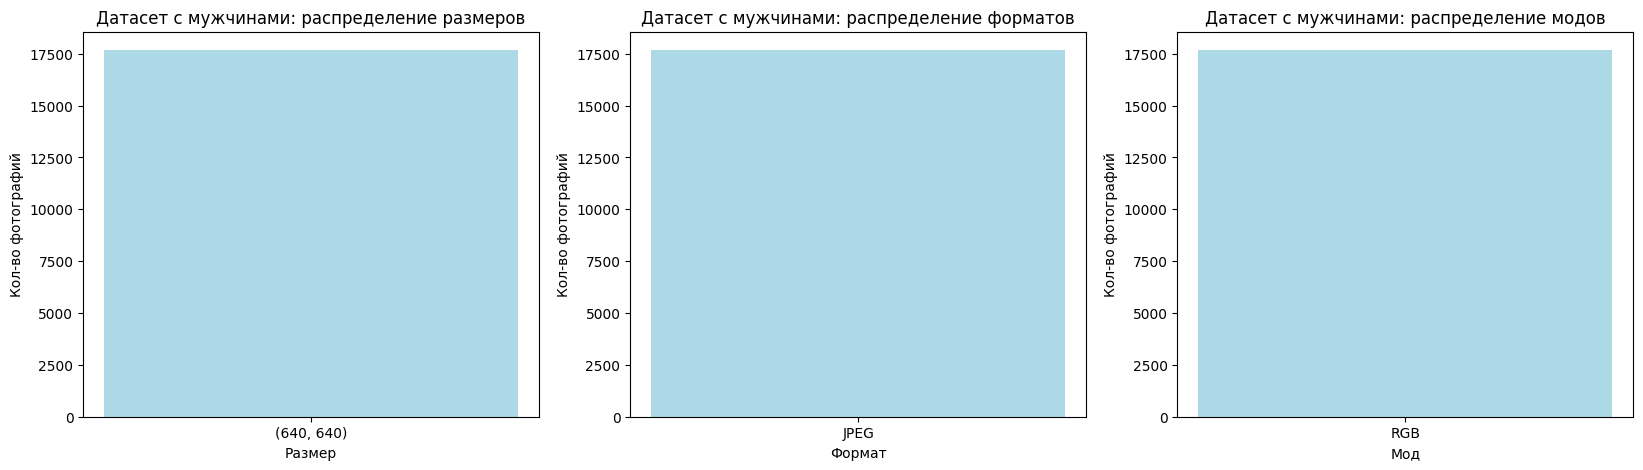

Кол-во различных размеров: 1
-----------------


Датасет с женщинами: анализ фото..: 100%|██████████| 9489/9489 [01:41<00:00, 93.88images/s] 


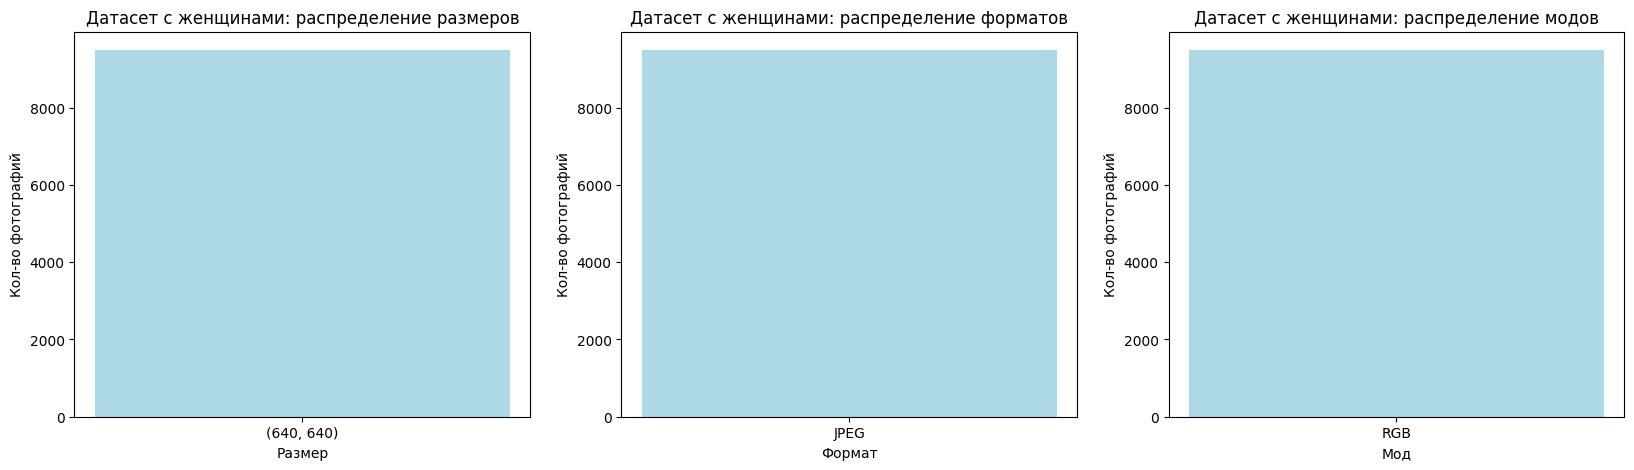

Кол-во различных размеров: 1
-----------------


In [37]:
# получаем списки с выборками
datas = [mans_data, womans_data]
data_names = ['Датасет с мужчинами', 'Датасет с женщинами']
data_paths = [mans_path, womans_path]
# проходимся по каждому набору
for i in range(len(datas)):
    # получаем набор даных, его имя и путь
    data = datas[i] 
    data_name = data_names[i]
    data_path = data_paths[i]
    # словари для статистики
    mode_stats = defaultdict(int)
    size_stats = defaultdict(int)
    format_stats = defaultdict(int)

    # проходимся по каждой фотографии в папке
    for img in tqdm(data, desc=f'{data_name}: анализ фото..', unit='images'):
        # путь к фотографии
        img_path = os.path.join(data_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # обновляем словари
        size_stats[f'{img.size}']+=1
        format_stats[img.format]+=1
        mode_stats[img.mode]+=1

    # разбиваем график на несколько
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    # парсим получившийся словарь
    counts = size_stats.values()
    size = size_stats.keys()
    # визуализируем результат
    ax[0].bar(size, counts, color='lightblue')
    ax[0].set_title(f'{data_name}: распределение размеров')
    ax[0].set_xlabel('Размер')
    ax[0].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = format_stats.values()
    format_ = format_stats.keys()
    # визуализируем результат
    ax[1].bar(format_, counts, color='lightblue')
    ax[1].set_title(f'{data_name}: распределение форматов')
    ax[1].set_xlabel('Формат')
    ax[1].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = mode_stats.values()
    mode = mode_stats.keys()
    # визуализируем результат
    ax[2].bar(mode, counts, color='lightblue')
    ax[2].set_title(f'{data_name}: распределение модов')
    ax[2].set_xlabel('Мод')
    ax[2].set_ylabel('Кол-во фотографий')

    plt.show()    

    print(f'Кол-во различных размеров: {len(size)}')

    print('-----------------')

Теперь, фотографии в обоих датасетах приведены к стандартному формату

### Проверка дубликатов

In [ ]:
# назначаем списки с кусками датасетов
datas = [mans_data, womans_data]
data_names = ['Датасет с мужчинами', 'Датасет с женщинами']
data_paths = [mans_path, womans_path]

# проходимся по каждому набору
for i in range(len(datas)): 
    # получаем набор даных, его имя и путь
    data = datas[i] 
    data_name = data_names[i]
    data_path = data_paths[i]

    # словарь с хэшами      
    hash_dict = {}
    # список с дубликатами
    duplicates = []
    # проходимся по каждой фотографии в папке
    for img in tqdm(data, desc=f'{data_name}: поиск дубликатов..', unit='image'):
        # путь к фотографии
        img_path = os.path.join(data_path, img)
        # вычисляем хэш
        image_hash = calculate_hash(img_path)
        # првоеряем, есть ли такой хэш в словаре
        if image_hash in hash_dict:
            # если да, то обновляем список с дубликатами
            duplicates.append((img_path, hash_dict[image_hash]))
        # если нет, то добавляем хэш в словарь
        else:
            hash_dict[image_hash] = img_path
    
    # путь к файлу метке
    flag_path = os.path.join(module_dir, f'faces_dup_{os.listdir(path_to_data3)[i]}.flag')

    if not os.path.exists(flag_path):
        # если дубликаты есть
        if duplicates:
            print(f'Датасет с кропами: найдены дубликаты - {len(duplicates)} штук')
            for dup in duplicates:
                print(f"Дубликат: {dup[0]} и {dup[1]}")
                # удаляем найденные дубликаты
                try:
                    os.remove(dup[0])
                    os.remove(dup[1])
                except:
                    pass
                # создаем файл метку, что дубликаты были удалены
                # назначаем путь
                flag_path = os.path.join(module_dir, f'faces_dup_{os.listdir(path_to_data3)[i]}.flag')
                # создаем файл-метку
                open(flag_path, 'a').close()
                

        # если дубликатов нет
        else:
            print(f'Датасет с кропами: дубликаты не найдены')
        # логирование
        print(f'Итоговое кол-во фото: {len(os.listdir(data_path))}')
        print('Поиск дубликатов закончен')

    else:
        print('Работа с дубликатами уже была проведена')


Датасет с мужчинами: поиск дубликатов..: 100%|██████████| 17517/17517 [00:02<00:00, 8111.10image/s]


Датасет с кропами: найдены дубликаты - 34 штук
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_3695.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_2417.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_3722.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_14751.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_41.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_17605.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_4117.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_13814.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_4325.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_302.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\man\man_4523.jpg и d:\Helper\ML

Датасет с женщинами: поиск дубликатов..: 100%|██████████| 9489/9489 [00:01<00:00, 7241.71image/s]

Датасет с кропами: найдены дубликаты - 57 штук
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1495.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1494.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1825.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1438.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1936.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1927.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1952.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1948.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_2037.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces\woman\woman_1384.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data

## Датасет 4: face_detection

### Загрузка данных

Для обучение модели детекции, я дополнительно загружу датасет с лицами, используя пакет `kaggle`

In [ ]:
# скачиваем последнюю версию
path = kagglehub.dataset_download("freak2209/face-data")

print("Путь к новому датасету:", path)

100%|██████████| 3.27G/3.27G [02:04<00:00, 28.2MB/s]

Extracting files...


Путь к новому датасету: C:\Users\alzot\.cache\kagglehub\datasets\freak2209\face-data\versions\1


Из путя, который вывели логи загрузки дополнительных данных, я перенес папку с новым датасетом в основную папку `Data25`

In [19]:
# путь к основной папке с данными
data_path = os.path.join(main_dir, r'Data\Data25')
# путь к папке с новым датасетом
path_to_data4 = os.path.join(data_path, 'Custom_Data')
# список папок в новом датасете
face_det_list = os.listdir(path_to_data4)
# логирование
print(f'Основная папка с данными: {data_path}')
print(f'Папка с новым датасетом: {path_to_data4}')
print(f'Количество папок в новом датасете: {len(face_det_list)}\n{face_det_list}')

Основная папка с данными: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25
Папка с новым датасетом: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\Custom_Data
Количество папок в новом датасете: 2
['images', 'labels']


### Структура данных

    -> Custom_Data\     # основная папка
        -> images\      # папка с фотографиями
            -> train\       # доп папка с фотографиями
                -> 04013.png        # фотография с лицом
                -> 04012.png        # фотография с лицом
                -> 04023.png        # фотография с лицом
                -> 04054.png        # фотография с лицом
                
        -> labels\      # папка с фотографиями
            -> train\       # доп папка с фотографиями
                -> 04013.txt        # файл с разметкой
                -> 04012.txt        # файл с разметкой
                -> 04023.txt        # файл с разметкой
                -> 04054.txt        # файл с разметкой

### Проверка на пропуски

In [ ]:
# проходимся по каждой папке
for i in range(len(face_det_list)):
    # путь к папке
    folder_name = face_det_list[i]
    folder_path = os.path.join(path_to_data4, folder_name)
    folder_path = os.path.join(folder_path, 'train')
    # получаем список файлов в папке
    files_list = os.listdir(folder_path)
    # логирование
    print(f'Путь к папке: {folder_path}')
    print(f'Кол-во файлов в папке {folder_name}: {len(files_list)}')


Путь к папке: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\Custom_Data\images\train
Кол-во файлов в папке images: 1154
Путь к папке: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\Custom_Data\labels\train
Кол-во файлов в папке labels: 1154


Видим, что для каждой фотографии есть файл с разметкой

### Проверка на формат фотографий

In [65]:
# путь к папке с фотографиями
images_path = os.path.join(path_to_data4, r'images\train')
print(images_path)

d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\Custom_Data\images\train


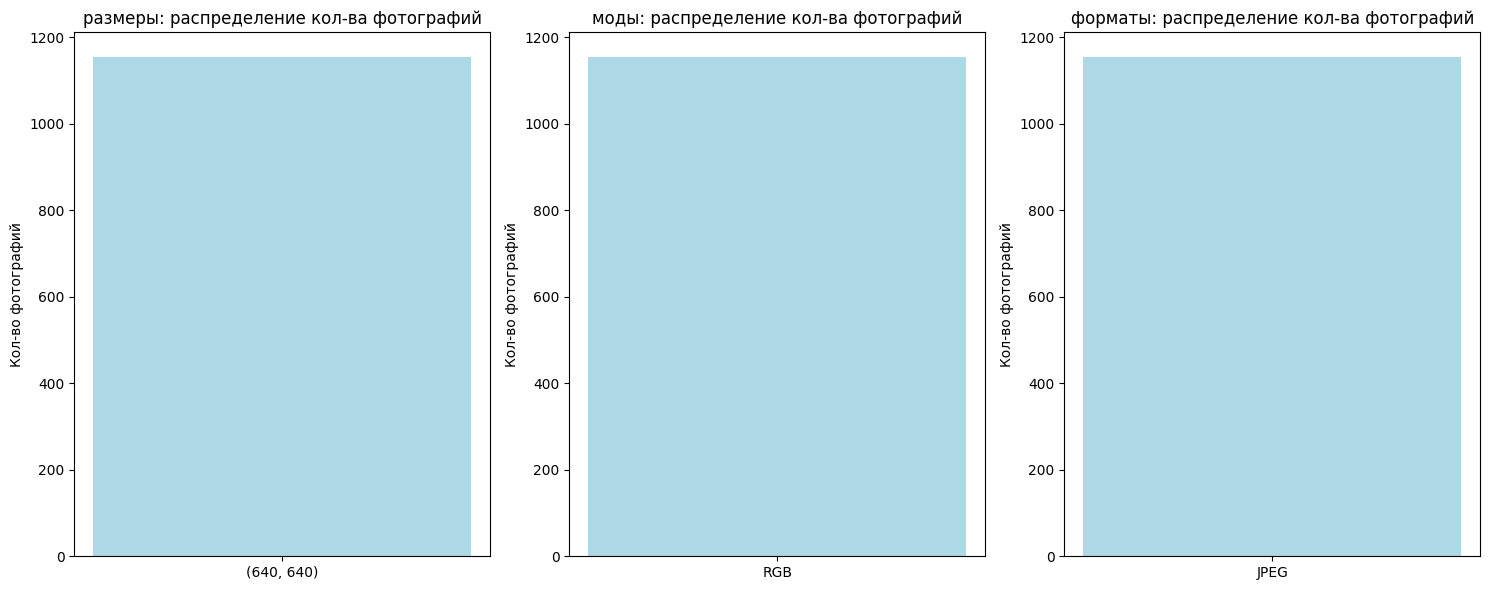

In [68]:
# словари для статистики
size_stats = defaultdict(int)
mode_stats = defaultdict(int)
format_stats = defaultdict(int)

# проходимся по кадому фото
for img in os.listdir(images_path):
    # путь к фотографии
    img_path = os.path.join(images_path, img_path)
    # читаем фотографию
    image = Image.open(img_path)
    # сохраняем данные о фотографии
    size_stats[f'{image.size}']+=1 
    mode_stats[image.mode]+=1 
    format_stats[image.format]+=1 

# список словарей
dict_list = [size_stats, mode_stats, format_stats]
dict_names = ['размеры', 'моды', 'форматы']

# вывод результатов
fig, ax = plt.subplots(1, len(dict_names), figsize=(15,6))
for i in range(len(dict_names)):
    # словарь
    stats = dict_list[i]
    stats_name = dict_names[i]
    # парсим словарь
    keys = stats.keys()
    values = stats.values()
    # строим график
    ax[i].bar(keys, values, color='lightblue')
    ax[i].set_title(f'{stats_name}: распределение кол-ва фотографий')
    ax[i].set_ylabel('Кол-во фотографий')

plt.tight_layout()
plt.show()

Видим, что все фотографии приведены в стандартном формате

## Подготовка данных для обучения

### Модель детекции

#### Предобработка данных

Для модели детекции, я буду использовать `4` датасет, который загрузил с `kaggle`, а также по `500` фотографий мужчин и женщин из датасета `faces`

Для начала, перенесу по `500` фотографий мужчин и женщин в датасет

In [20]:
# путь к набору данных для модели детекции
face_detect_path = os.path.join(data_path, 'face_detection')
os.makedirs(face_detect_path, exist_ok=True)
print(f'Путь к набору данных с детекцией: {face_detect_path}')

Путь к набору данных с детекцией: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\face_detection


Также, создаем 2 папки - `images`, `labels`

In [21]:
# пути к папкам с фото и разметками
det_images_path = os.path.join(face_detect_path, 'images')
det_labels_path = os.path.join(face_detect_path, 'labels')
# создаем папки
os.makedirs(det_images_path, exist_ok=True)
os.makedirs(det_labels_path, exist_ok=True)

Переносим имеющиеся фотографии из датасета с `kaggle` в новую папку

In [34]:
# папка с фотографиями
images_path = os.path.join(path_to_data4, r'images\train')
images_path_fin = os.path.join(face_detect_path, r'images')
images = os.listdir(images_path)
print(images_path)
# папка с разметками
labels_path = os.path.join(path_to_data4, r'labels\train')
labels_path_fin = os.path.join(face_detect_path, r'labels')
labels = os.listdir(labels_path)
print(labels_path)
# список с этим папками
parts_path = [images_path, labels_path]
parts = [images, labels]
parts_path_fin = [images_path_fin, labels_path_fin]
parts_name = ['images', 'labels']
# проходимся по каждой фотографии и разметки в исходном датасете
for i in range(len(parts_name)):
    # данные
    data = parts[i]
    data_name = parts_name[i]
    data_path = parts_path[i]
    data_path_fin = parts_path_fin[i]
    # счетчик файлов
    counter = 0
    # проходимся по файлам
    for file in tqdm(data, desc='Копирование данных..', unit='file'):
        # находим путь к данным
        file_path = os.path.join(data_path, file)
        file_path_fin = os.path.join(data_path_fin, file)
        # копируем файлы
        shutil.copy(file_path, file_path_fin)
        # обновляем счетчик
        counter+=1
    # логирование
    print(f'Папка {data_name}: перенесено {counter} файлов')



d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\Custom_Data\images\train
d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\Custom_Data\labels\train


Копирование данных..: 100%|██████████| 1154/1154 [00:09<00:00, 115.85file/s]


Папка images: перенесено 1154 файлов


Копирование данных..: 100%|██████████| 1154/1154 [00:01<00:00, 772.87file/s]

Папка labels: перенесено 1154 файлов


Теперь перенесем по `500` фотографий `мужчин` и `женщин` из третьего датасета

In [22]:
womans_samples = random.sample(os.listdir(womans_path), 500)
mans_samples = random.sample(os.listdir(mans_path), 500)

# список с кусками даных
samples = [womans_samples, mans_samples]
samples_names = ['woman', 'man']
samples_paths = [womans_path, mans_path]

# проходимся по каждой выборке
for i in range(len(samples)):
    # получаем данные
    sample = samples[i]
    sample_name = samples_names[i]
    sample_path = samples_paths[i]
    # счетчик фотографий
    counter = 0
    # проходимся по каждой фотографии
    for img in tqdm(sample, desc=f'{sample_name}: копирование фотографий..', unit='image'):
        # путь к фотографии
        img_path = os.path.join(sample_path, img)
        img_path_fin = os.path.join(det_images_path, img)
        # копируем файлы
        shutil.copy(img_path, img_path_fin)
        # обновляем счетчик
        counter+=1
    # логирование
    print(f'{sample_name}: {counter} фотографий скопировано')




woman: копирование фотографий..:   0%|          | 0/500 [00:00<?, ?image/s]

woman: копирование фотографий..: 100%|██████████| 500/500 [00:09<00:00, 52.81image/s]


woman: 500 фотографий скопировано


man: копирование фотографий..: 100%|██████████| 500/500 [00:09<00:00, 51.36image/s]

man: 500 фотографий скопировано


Все фотографии для детекции были перенесены!

In [56]:
len(os.listdir(images_path_fin))

2195

Теперь, надо переразметить и доразметить имеющие фотографии. Для этого я буду использовать веб-приложение для разметки `YAT` - `YOLO Annotation Tool`. Это удобное приложение для разметки данных и сохранения разметки в различных форматах. Я буду использовать формат `YOLO`.

Для запуска приложения, надо запустить файл `Annotation.html`

Также, надо создать файл `classes.txt` с описанием классов - в моем случае, 1 класс `face`

**Разметка до:**

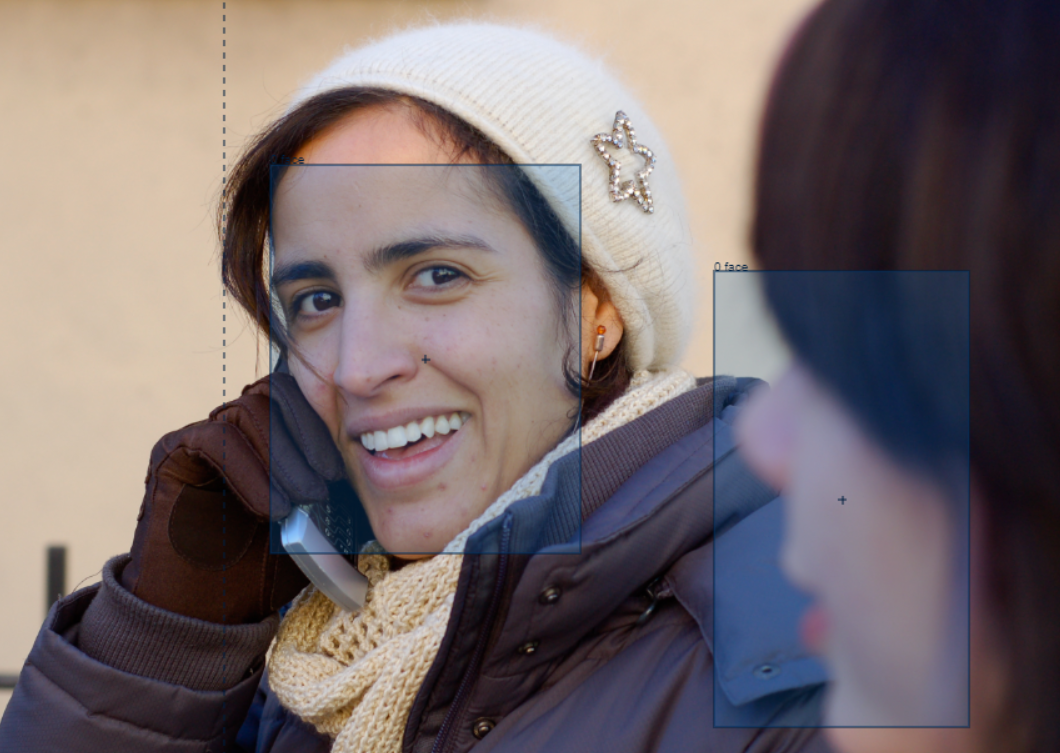
*не видно большую часть лица*

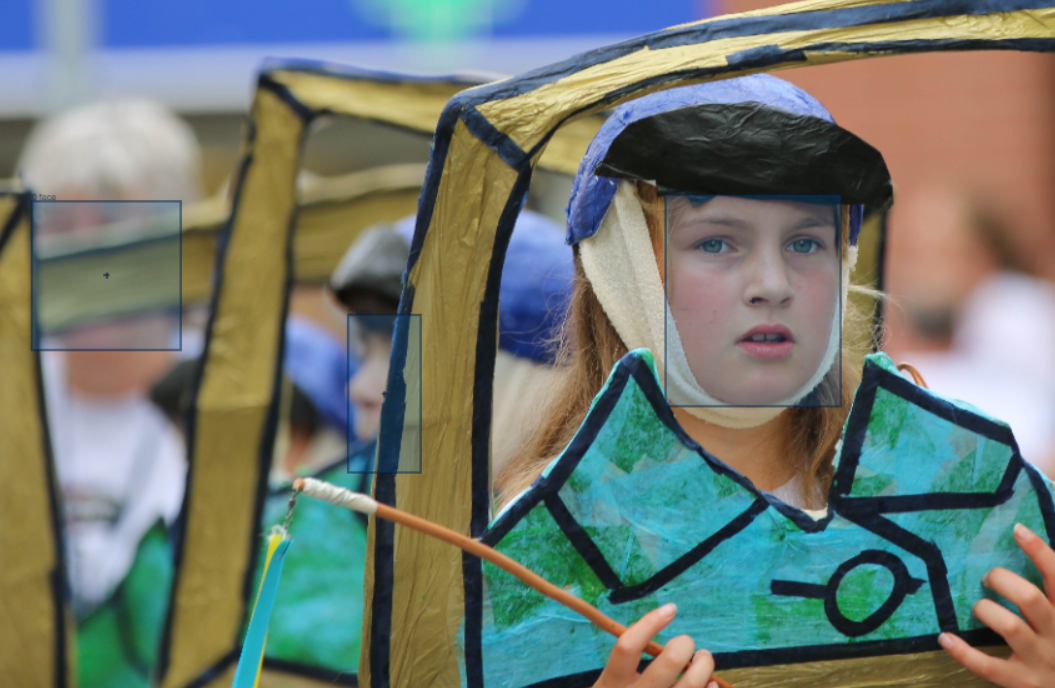
*не видно 1 и 2 лицо*

**Разметка после:**

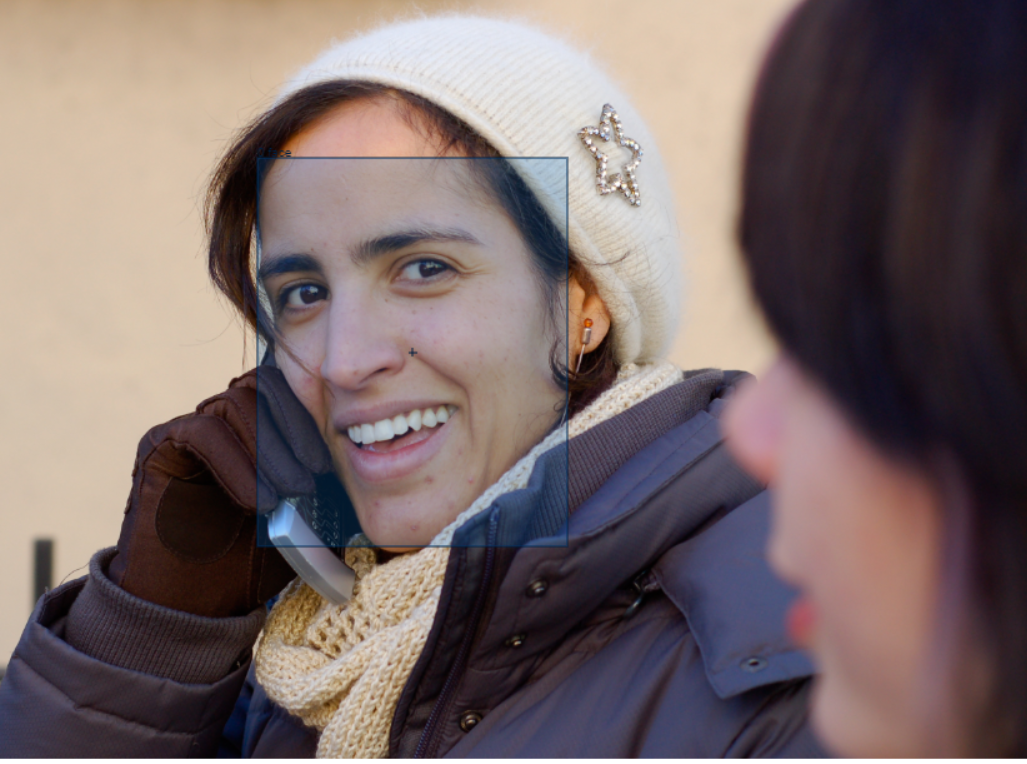

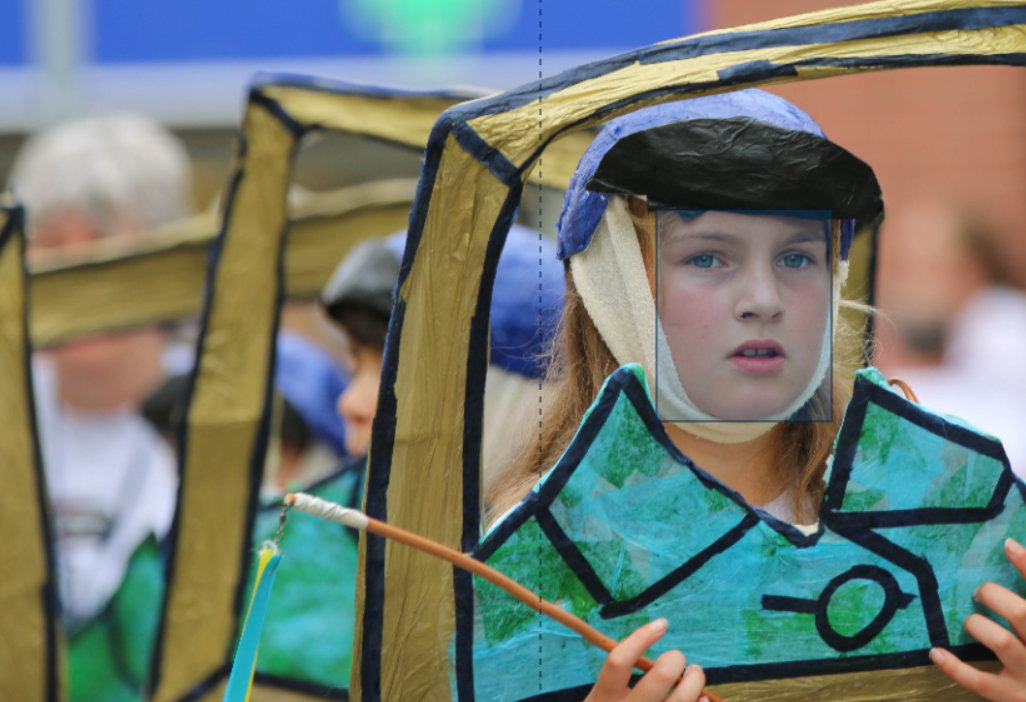

**такие, и подобные фотографии я переразметил**

После переразметки, я сохранил разметки в формате `YOLO` и скачал архив

In [57]:
# путь к архиву
bboxes_archive = os.path.join(main_dir, r'Data\bboxes.zip')
labels_path = os.path.join(face_detect_path, 'labels')
images_path = os.path.join(face_detect_path, 'images')
# разархивируем новые разметки 
with zipfile.ZipFile(bboxes_archive, 'r') as zip:
    zip.extractall(labels_path)

print(f'{len(os.listdir(images_path))} - всего фотографий')
print(f'{len(os.listdir(labels_path))} - всего файлов с разметкой')

2195 - всего фотографий
2195 - всего файлов с разметкой


Приведем все изображения к одному формату - `jpeg`

In [59]:
# проходимся по каждой фотографии
for img in tqdm(os.listdir(images_path), desc='Заменяем формат на JPEG', unit='image'):
    # путь к фотографии
    img_path = os.path.join(images_path, img)
    # читаем фотографию
    imag = Image.open(img_path)
    # меняем формат на jpeg
    if imag.size != (640,640) or imag.format != 'JPEG':
        imag = imag.resize((640,640), resample=Image.Resampling.LANCZOS)
        img = imag.save(img_path.split('.')[0]+'.jpg', format='JPEG')
        imag.close()
        os.remove(img_path)


Заменяем формат на JPEG: 100%|██████████| 2196/2196 [04:48<00:00,  7.61image/s]


Теперь, у каждой фотографии есть разметка в формате `YOLO`, и они все сохранены в едином формате. Можно разделить датасет на 3 выборки, `train`, `test` и `valid`

#### Разбиение на выборки

In [61]:
# назначем пути к папкам с выборками и создаем их
parts_names = ['train', 'test', 'valid']
# проходимся по каждой выборке
for part in parts_names:
    # путь к выборке
    direction = os.path.join(face_detect_path, part)
    # создаем папку к выборке
    os.makedirs(direction, exist_ok=True)
    # пути к фото и выборками
    img_paths = os.path.join(direction, 'images')
    lbl_paths = os.path.join(direction, 'labels')
    # создаем папки с фото и разметками
    os.makedirs(img_paths, exist_ok=True)
    os.makedirs(lbl_paths, exist_ok=True)

После создания папок, разбиваем датасет на выборки и переносим по выборкам

In [62]:
data = os.listdir(images_path)
train, test = train_test_split(data, test_size=0.3, random_state=42)
valid, test = train_test_split(test, test_size=0.5, random_state=42)
print(f'Размер тренировочной выборки: {len(train)}')
print(f'Размер тестовой выборки: {len(test)}')
print(f'Размер валидационной выборки: {len(valid)}')

Размер тренировочной выборки: 1536
Размер тестовой выборки: 330
Размер валидационной выборки: 329


In [68]:
# список с выборками
parts = [train, test, valid]

# проходимся по выборкам
for i in range(len(parts_names)):
    # данные
    part = parts[i]
    name = parts_names[i]
    part_path = os.path.join(face_detect_path, name)
    labels = os.path.join(part_path, 'labels')
    images = os.path.join(part_path, 'images')
    counter = 0
    # проходимся по фотографиям
    for image_name in tqdm(part, desc=f'Перенос данных в выборку {name}'):
        # путь к фотографии
        image_path = os.path.join(images_path, image_name) 
        label_path = os.path.join(labels_path, image_name.split('.')[0]+'.txt') 
        # копируем фото и разметку в нужную папку
        shutil.copy(image_path, os.path.join(images, image_name))
        shutil.copy(label_path, os.path.join(labels, image_name.split('.')[0]+'.txt'))
        counter +=1 
    print(f'Перенесено {counter} фото и разметок')

    

Перенос данных в выборку train: 100%|██████████| 1536/1536 [00:03<00:00, 441.31it/s]


Перенесено 1536 фото и разметок


Перенос данных в выборку test: 100%|██████████| 330/330 [00:06<00:00, 54.83it/s] 


Перенесено 330 фото и разметок


Перенос данных в выборку valid: 100%|██████████| 329/329 [00:10<00:00, 31.12it/s]

Перенесено 329 фото и разметок


После разбиения, можно удалить изначальные общие папки с фотографиями и разметками

### Модель распознавания

для того, чтобы реализовать алгоритм распознавания, я буду использовать датасет `archive-3` - на кропах лиц я буду делать распознавание, а выводить полное фото из папки с оригинальными фотографиями

In [89]:
path_to_data2

'd:\\Helper\\MLBazyak\\chemp\\face_recognitionV2\\Data\\Data25\\archive-3'

In [90]:
# получаем пути к оригинальным фотографиям и кропам
path_to_orig = os.path.join(path_to_data2, r'Original Images\Original Images')
path_to_crop = os.path.join(path_to_data2, r'Faces\Faces')
# логирование
print(path_to_orig)
print(path_to_crop)

d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images
d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces


In [ ]:
# создаем пути для папок с тренировочными и тестовыми выборками
face_rec = os.path.join(data_path, 'face_rec')
crops_path = os.path.join(face_rec, 'crop')
orig_path = os.path.join(face_rec, 'orig')
parts_name = ['train', 'test']
parts = [crops_path, orig_path]
# создаем папки
os.makedirs(face_rec, exist_ok=True)
os.makedirs(crops_path, exist_ok=True)
os.makedirs(orig_path, exist_ok=True)
# создаем папки с выборками
for part in parts:
    os.makedirs(os.path.join(part, parts_name[0]), exist_ok=True)
    os.makedirs(os.path.join(part, parts_name[1]), exist_ok=True)

In [115]:
some_name = orig_img_list[1].split('\\')[-1]
print(some_name)
print(os.path.join(path_to_crop, some_name))

Akshay Kumar_1.jpg
d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Akshay Kumar_1.jpg


In [131]:
# проходимся по каждому имени
for name in os.listdir(path_to_orig):
    # логирование
    print(name)
    name_path = os.path.join(path_to_orig, name)
    name_data = os.listdir(name_path)
    # логирование
    print(f'Всего фотографий: {len(name_data)}')
    # train, test = train_test_split(name_data, test_size=3, random_state=42)
    datasets = train_test_split(name_data, test_size=3, random_state=42)
    # логирование
    print(f'Тренировочная выборка: {len(train)}')
    print(f'Тестовая выборка: {len(test)}')
    # проходимся по каждой выборке
    for i in range(len(datasets)):
        # получаем датасет и его имя
        dataset = datasets[i]
        data_name = parts_name[i]
        # проходимся по каждой фотографии 
        for img in tqdm(dataset, desc=f'{name} - {data_name}: обработка..', unit='image'):
            
            # начальные пути
            img_path_orig1 = os.path.join(name_path, img)
            img_path_crop1 = os.path.join(path_to_crop, img)

            # конечные пути
            img_path_orig2 = os.path.join(os.path.join(orig_path, data_name), img)
            img_path_crop2 = os.path.join(os.path.join(crops_path, data_name), img)
            
            # копируем фотографии 
            shutil.copy(img_path_orig1, img_path_orig2)
            shutil.copy(img_path_crop1, img_path_crop2)

Akshay Kumar
Всего фотографий: 50
Тренировочная выборка: 88
Тестовая выборка: 3


Akshay Kumar - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 598.10image/s]


Alexandra Daddario
Всего фотографий: 92
Тренировочная выборка: 88
Тестовая выборка: 3


Alexandra Daddario - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 126.57image/s]


Alia Bhatt
Всего фотографий: 79
Тренировочная выборка: 88
Тестовая выборка: 3


Alia Bhatt - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 208.35image/s]


Amitabh Bachchan
Всего фотографий: 74
Тренировочная выборка: 88
Тестовая выборка: 3


Amitabh Bachchan - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 214.18image/s]


Andy Samberg
Всего фотографий: 92
Тренировочная выборка: 88
Тестовая выборка: 3


Andy Samberg - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 599.81image/s]


Anushka Sharma
Всего фотографий: 68
Тренировочная выборка: 88
Тестовая выборка: 3


Anushka Sharma - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 749.88image/s]


Billie Eilish
Всего фотографий: 98
Тренировочная выборка: 88
Тестовая выборка: 3


Billie Eilish - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 428.89image/s]


Brad Pitt
Всего фотографий: 120
Тренировочная выборка: 88
Тестовая выборка: 3


Brad Pitt - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 296.05image/s]


Camila Cabello
Всего фотографий: 87
Тренировочная выборка: 88
Тестовая выборка: 3


Camila Cabello - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 193.89image/s]


Charlize Theron
Всего фотографий: 78
Тренировочная выборка: 88
Тестовая выборка: 3


Charlize Theron - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 750.14image/s]


Claire Holt
Всего фотографий: 96
Тренировочная выборка: 88
Тестовая выборка: 3


Claire Holt - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 720.79image/s]


Courtney Cox
Всего фотографий: 76
Тренировочная выборка: 88
Тестовая выборка: 3


Courtney Cox - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 417.66image/s]


Dwayne Johnson
Всего фотографий: 61
Тренировочная выборка: 88
Тестовая выборка: 3


Dwayne Johnson - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 563.70image/s]


Elizabeth Olsen
Всего фотографий: 71
Тренировочная выборка: 88
Тестовая выборка: 3


Elizabeth Olsen - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 314.79image/s]


Ellen Degeneres
Всего фотографий: 75
Тренировочная выборка: 88
Тестовая выборка: 3


Ellen Degeneres - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 189.37image/s]


Henry Cavill
Всего фотографий: 104
Тренировочная выборка: 88
Тестовая выборка: 3


Henry Cavill - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 419.28image/s]


Hrithik Roshan
Всего фотографий: 101
Тренировочная выборка: 88
Тестовая выборка: 3


Hrithik Roshan - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 237.82image/s]


Hugh Jackman
Всего фотографий: 110
Тренировочная выборка: 88
Тестовая выборка: 3


Hugh Jackman - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 303.52image/s]


Jessica Alba
Всего фотографий: 108
Тренировочная выборка: 88
Тестовая выборка: 3


Jessica Alba - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 169.30image/s]


Kashyap
Всего фотографий: 30
Тренировочная выборка: 88
Тестовая выборка: 3


Kashyap - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 115.86image/s]


Lisa Kudrow
Всего фотографий: 70
Тренировочная выборка: 88
Тестовая выборка: 3


Lisa Kudrow - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 813.95image/s]


Margot Robbie
Всего фотографий: 72
Тренировочная выборка: 88
Тестовая выборка: 3


Margot Robbie - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 722.62image/s]


Marmik
Всего фотографий: 32
Тренировочная выборка: 88
Тестовая выборка: 3


Marmik - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 120.92image/s]


Natalie Portman
Всего фотографий: 103
Тренировочная выборка: 88
Тестовая выборка: 3


Natalie Portman - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 177.74image/s]


Priyanka Chopra
Всего фотографий: 102
Тренировочная выборка: 88
Тестовая выборка: 3


Priyanka Chopra - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 108.54image/s]


Robert Downey Jr
Всего фотографий: 113
Тренировочная выборка: 88
Тестовая выборка: 3


Robert Downey Jr - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 247.59image/s]


Roger Federer
Всего фотографий: 77
Тренировочная выборка: 88
Тестовая выборка: 3


Roger Federer - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 93.29image/s]


Tom Cruise
Всего фотографий: 58
Тренировочная выборка: 88
Тестовая выборка: 3


Tom Cruise - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 242.61image/s]


Vijay Deverakonda
Всего фотографий: 115
Тренировочная выборка: 88
Тестовая выборка: 3


Vijay Deverakonda - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 189.98image/s]


Virat Kohli
Всего фотографий: 49
Тренировочная выборка: 88
Тестовая выборка: 3


Virat Kohli - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 218.13image/s]


Zac Efron
Всего фотографий: 91
Тренировочная выборка: 88
Тестовая выборка: 3


Zac Efron - test: обработка..: 100%|██████████| 3/3 [00:00<00:00, 152.85image/s]


In [139]:
print(f'Размер тестовой выборки: {len(os.listdir(os.path.join(crops_path, "test")))}')
print(f'Размер тестовой выборки: {len(os.listdir(os.path.join(orig_path, "test")))}')
print(f'Размер тренировочной выборки: {len(os.listdir(os.path.join(crops_path, "train")))}')
print(f'Размер тренировочной выборки: {len(os.listdir(os.path.join(orig_path, "train")))}')

Размер тестовой выборки: 93
Размер тестовой выборки: 93
Размер тренировочной выборки: 2459
Размер тренировочной выборки: 2459


датасет для распознавания успешно разделен на 2 выборки
теперь можно сохранить их в архив

## Cохранение данных

In [141]:
face_det_zip = os.path.join(data_path, 'face_detection.zip')
face_rec_zip = os.path.join(data_path, 'face_recognition.zip')
print(face_det_zip)
print(face_rec_zip)

d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\face_detection.zip
d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\face_recognition.zip


In [143]:
# Создание ZIP-архива
with zipfile.ZipFile(face_det_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(face_detect_path):
        for file in files:
            file_path = os.path.join(root, file)
            # Добавляем файл в архив, сохраняя относительный путь
            arcname = os.path.relpath(file_path, start=face_detect_path)
            zipf.write(file_path, arcname)

print(f"Папка {face_detect_path} успешно заархивирована в {face_det_zip}")


Папка d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\face_detection успешно заархивирована в d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\face_detection.zip


In [ ]:
# Создание ZIP-архива
with zipfile.ZipFile(face_rec_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(face_rec):
        for file in files:
            file_path = os.path.join(root, file)
            # Добавляем файл в архив, сохраняя относительный путь
            arcname = os.path.relpath(file_path, start=face_rec)
            zipf.write(file_path, arcname)

print(f"Папка {face_rec} успешно заархивирована в {face_rec_zip}")


Папка d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\face_rec успешно заархивирована в d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\face_recognition.zip
